# Logit Analysis Results

Analysis of logit data to understand the effect of system prompts on model responses.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

# Set plot style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [2]:
# File paths
LOGPROBS_SYS_PATH = '../data/Qwen3-30B-A3B-Instruct-2507/logprobs_with_sys.csv'
LOGPROBS_NO_SYS_PATH = '../data/Qwen3-30B-A3B-Instruct-2507/logprobs_no_sys.csv'
RATINGS_PATH = '../../ratings/data/Qwen3-30B-A3B-Instruct-2507/response_ratings.csv'
NORMS_PATH = '../../../data/VanArsdall_Blunt_NormData.xlsx'

# Load data
df_sys = pd.read_csv(LOGPROBS_SYS_PATH)
df_no_sys = pd.read_csv(LOGPROBS_NO_SYS_PATH)
df_ratings = pd.read_csv(RATINGS_PATH)
df_norms = pd.read_excel(NORMS_PATH, sheet_name='Words')

print("Loaded data shapes:")
print(f"Sys: {df_sys.shape}")
print(f"No Sys: {df_no_sys.shape}")
print(f"Ratings: {df_ratings.shape}")
print(f"Norms: {df_norms.shape}")

Loaded data shapes:
Sys: (6300, 8)
No Sys: (6300, 8)
Ratings: (6000, 9)
Norms: (1200, 32)


In [3]:
# Preprocessing

# Rename no_sys columns
df_no_sys = df_no_sys.rename(columns={
    'average_log_probs': 'average_log_probs_no_sys',
    'role_log_probs': 'role_log_probs_no_sys',
    'role_period_log_prob': 'role_period_log_prob_no_sys',
    'first_100_response_log_probs': 'first_100_response_log_probs_no_sys',
    'first_100_response_text_len': 'first_100_response_text_len_no_sys'
})

# Merge logprobs
df_merged = pd.merge(df_sys, df_no_sys, on=['role_name', 'task_name', 'sample_idx'], how='inner')

# Merge with ratings
df_merged = pd.merge(df_merged, df_ratings, on=['role_name', 'task_name', 'sample_idx'], how='left')

# Merge with norms
df_norms['Word_lower'] = df_norms['Word'].str.lower().str.strip()
df_merged['role_name_lower'] = df_merged['role_name'].str.lower().str.strip()

df_full = pd.merge(df_merged, df_norms, left_on='role_name_lower', right_on='Word_lower', how='left')

# Parse logprobs lists
def parse_list(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    return x

df_full['first_100_response_log_probs'] = df_full['first_100_response_log_probs'].apply(parse_list)
df_full['first_100_response_log_probs_no_sys'] = df_full['first_100_response_log_probs_no_sys'].apply(parse_list)

print(f"Merged dataframe shape: {df_full.shape}")

Merged dataframe shape: (6300, 53)


## 1) Role Deviations Analysis

In [4]:
deviation_cols = ['assistant_refusal', 'role_refusal', 'identify_as_assistant', 'deny_internal_experience']

# Ensure boolean
for col in deviation_cols:
    df_full[col] = df_full[col].astype(bool)

df_full['has_deviation'] = df_full[deviation_cols].any(axis=1)

print("Deviation counts:")
print(df_full[deviation_cols].sum())

# Avg logits for deviations
deviation_stats = []
for col in deviation_cols:
    deviated = df_full[df_full[col]]
    if not deviated.empty:
        avg_sys = deviated['average_log_probs'].mean()
        avg_no_sys = deviated['average_log_probs_no_sys'].mean()
        deviation_stats.append({'Deviation Type': col, 'Avg Logits (Sys)': avg_sys, 'Avg Logits (No Sys)': avg_no_sys, 'Count': len(deviated)})

dev_df = pd.DataFrame(deviation_stats)
print("\nDeviation Statistics:")
print(dev_df)

Deviation counts:
assistant_refusal           333
role_refusal                369
identify_as_assistant       487
deny_internal_experience    672
dtype: int64

Deviation Statistics:
             Deviation Type  Avg Logits (Sys)  Avg Logits (No Sys)  Count
0         assistant_refusal         -0.471452            -0.527933    333
1              role_refusal         -0.481125            -0.593874    369
2     identify_as_assistant         -0.448091            -0.584006    487
3  deny_internal_experience         -0.469165            -0.707210    672


## 1b) Distinguishing Role-Specific vs Generic Deviations

Here we analyze the difference in logits for deviated responses. 
- **High Logit Diff (Sys >> No Sys)**: The deviation is likely **Role-Specific** (the model was 'forced' into this response by the role).
- **Low Logit Diff (Sys ≈ No Sys)**: The deviation is likely **Generic** (the model would have refused/deviated anyway, perhaps due to the task).

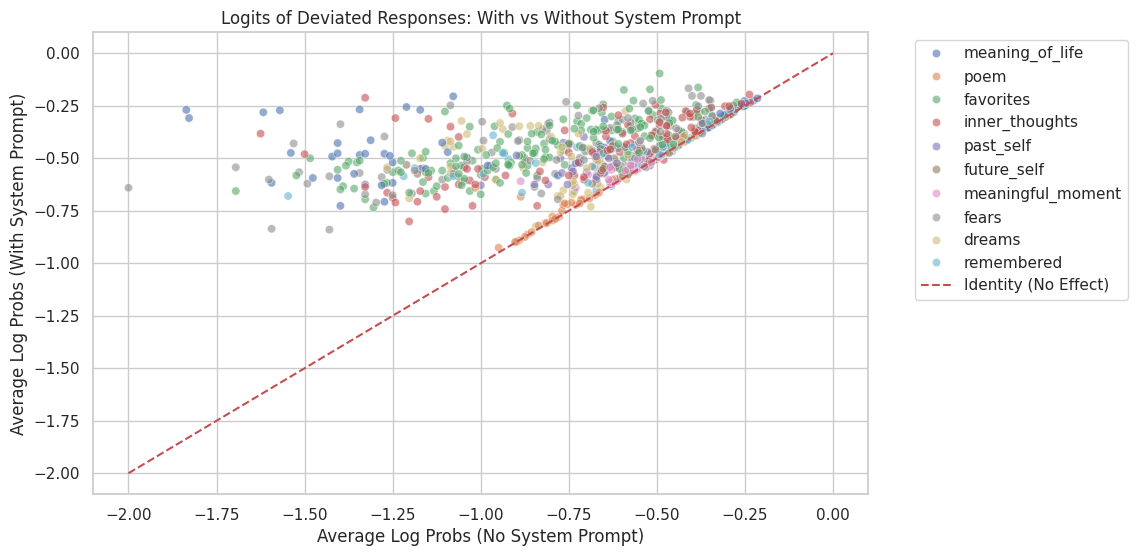


--- Top Roles by Logit Diff (Role-Specific Deviations) ---
               mean  count
role_name                 
butler     0.871094      1
cop        0.804688      9
hair       0.781250      2
lock       0.778809      4
blouse     0.761719      2
rain       0.757812      1
umpire     0.755400     17
spatula    0.743750      5
maze       0.738281      2
shovel     0.709961      4

--- Bottom Roles by Logit Diff (Generic Deviations) ---
                       mean  count
role_name                         
root               0.216732     15
nation             0.214565      7
puzzle             0.214124     19
professor          0.184766     20
sheet              0.145132     13
llm                0.088320     50
AI                 0.034688     50
helpful assistant  0.028652     50
assistant          0.023613     50
AI assistant       0.011719     50

--- Top Tasks by Logit Diff (Role-Specific Deviations) ---
                       mean  count
task_name                         
meaning_o

In [5]:
df_deviations = df_full[df_full['has_deviation']].copy()
df_deviations['logit_diff'] = df_deviations['average_log_probs'] - df_deviations['average_log_probs_no_sys']

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_deviations, x='average_log_probs_no_sys', y='average_log_probs', hue='task_name', alpha=0.6)
plt.plot([-2, 0], [-2, 0], 'r--', label='Identity (No Effect)')
plt.title('Logits of Deviated Responses: With vs Without System Prompt')
plt.xlabel('Average Log Probs (No System Prompt)')
plt.ylabel('Average Log Probs (With System Prompt)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Analyze by Role
print("\n--- Top Roles by Logit Diff (Role-Specific Deviations) ---")
role_diff = df_deviations.groupby('role_name')['logit_diff'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(role_diff.head(10))
print("\n--- Bottom Roles by Logit Diff (Generic Deviations) ---")
print(role_diff.tail(10))

# Analyze by Task
print("\n--- Top Tasks by Logit Diff (Role-Specific Deviations) ---")
task_diff = df_deviations.groupby('task_name')['logit_diff'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print(task_diff.head(10))
print("\n--- Bottom Tasks by Logit Diff (Generic Deviations) ---")
print(task_diff.tail(10))

# Analyze by Deviation Type
print("\n--- Deviation Types by Logit Diff ---")
type_stats = []
for col in deviation_cols:
    subset = df_deviations[df_deviations[col]]
    if not subset.empty:
        type_stats.append({
            'Deviation Type': col,
            'Mean Logit Diff': subset['logit_diff'].mean(),
            'Count': len(subset)
        })
print(pd.DataFrame(type_stats).sort_values('Mean Logit Diff', ascending=False))

In [6]:
# Filter out deviations for remainder of analysis
df_clean = df_full[~df_full['has_deviation']].copy()
print(f"\nClean dataframe shape (Deviations removed): {df_clean.shape}")


Clean dataframe shape (Deviations removed): (5545, 54)


## 2) First 100 Token Logprobs Plot

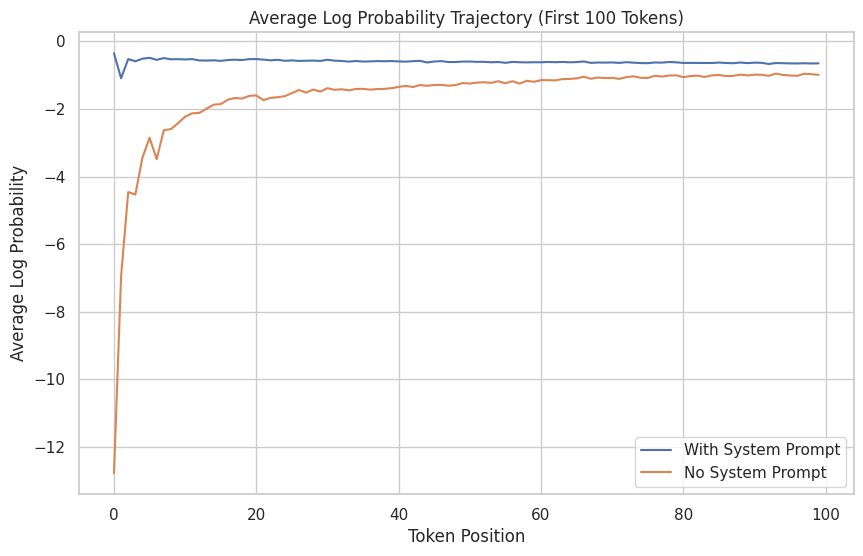

In [7]:
def get_avg_trajectory(series_of_lists):
    # Find max length
    max_len = series_of_lists.apply(len).max()
    if pd.isna(max_len) or max_len == 0:
        return np.array([])
    
    # Create a matrix
    matrix = np.full((len(series_of_lists), 100), np.nan)
    for i, lst in enumerate(series_of_lists):
        if len(lst) > 0:
            length = min(len(lst), 100)
            matrix[i, :length] = lst[:length]
            
    return np.nanmean(matrix, axis=0)

avg_traj_sys = get_avg_trajectory(df_clean['first_100_response_log_probs'])
avg_traj_no_sys = get_avg_trajectory(df_clean['first_100_response_log_probs_no_sys'])

plt.figure(figsize=(10, 6))
plt.plot(avg_traj_sys, label='With System Prompt')
plt.plot(avg_traj_no_sys, label='No System Prompt')
plt.xlabel('Token Position')
plt.ylabel('Average Log Probability')
plt.title('Average Log Probability Trajectory (First 100 Tokens)')
plt.legend()
plt.show()

## 3) Per-Task Convergence and Residual Gap (at 50 & 100)

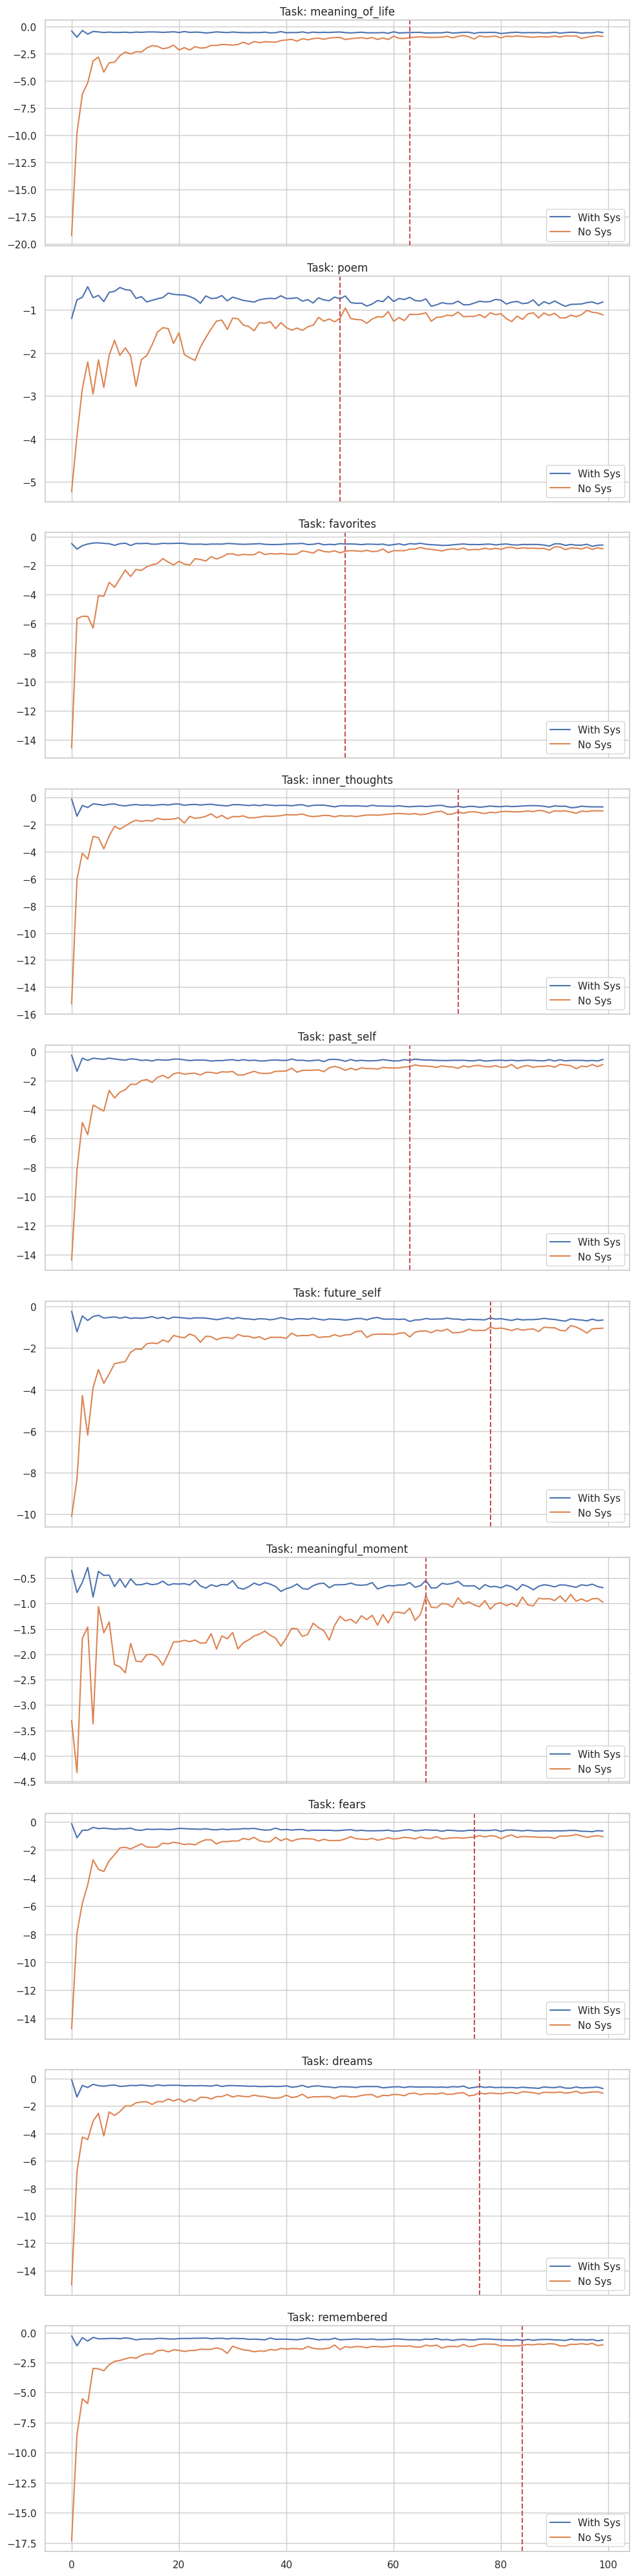

Estimated Convergence Points per Task:
{'meaning_of_life': 63, 'poem': 50, 'favorites': 51, 'inner_thoughts': 72, 'past_self': 63, 'future_self': 78, 'meaningful_moment': 66, 'fears': 75, 'dreams': 76, 'remembered': 84}

Residual Gap @ 50 per Task:
{'meaning_of_life': np.float64(0.4995829574632139), 'poem': np.float64(0.5753599379286671), 'favorites': np.float64(0.4197005265826692), 'inner_thoughts': np.float64(0.7361200993193268), 'past_self': np.float64(0.48463266581761777), 'future_self': np.float64(0.7413597718159493), 'meaningful_moment': np.float64(0.7995090281882253), 'fears': np.float64(0.7022029209503058), 'dreams': np.float64(0.7860814261729772), 'remembered': np.float64(0.5641360272709122)}

Residual Gap @ 100 per Task:
{'meaning_of_life': np.float64(0.357765793800354), 'poem': np.float64(0.29988591843003387), 'favorites': np.float64(0.258780935247647), 'inner_thoughts': np.float64(0.2983771238290487), 'past_self': np.float64(0.346582280494518), 'future_self': np.float64(0.3

In [8]:
def get_residual_gap_at_k(traj_sys, traj_no_sys, k):
    if k >= len(traj_sys):
        return np.nan
    return np.abs(traj_sys[k] - traj_no_sys[k])

tasks = df_clean['task_name'].unique()
task_convergence = {}
task_residual_gap_50 = {}
task_residual_gap_100 = {}

fig, axes = plt.subplots(len(tasks), 1, figsize=(10, 4*len(tasks)), sharex=True)
if len(tasks) == 1: axes = [axes]

for i, task in enumerate(tasks):
    task_df = df_clean[df_clean['task_name'] == task]
    
    traj_sys = get_avg_trajectory(task_df['first_100_response_log_probs'])
    traj_no_sys = get_avg_trajectory(task_df['first_100_response_log_probs_no_sys'])
    
    ax = axes[i]
    ax.plot(traj_sys, label='With Sys')
    ax.plot(traj_no_sys, label='No Sys')
    ax.set_title(f'Task: {task}')
    ax.legend()
    
    # Estimate convergence: first index where diff < 0.5 for 5 consecutive tokens
    diff = np.abs(traj_sys - traj_no_sys)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    
    task_convergence[task] = conv_idx
    task_residual_gap_50[task] = get_residual_gap_at_k(traj_sys, traj_no_sys, 49) # 0-indexed
    task_residual_gap_100[task] = get_residual_gap_at_k(traj_sys, traj_no_sys, 99) # 0-indexed
    
    if not np.isnan(conv_idx):
        ax.axvline(conv_idx, color='r', linestyle='--', label=f'Conv: {conv_idx}')

plt.tight_layout()
plt.show()

print("Estimated Convergence Points per Task:")
print(task_convergence)
print("\nResidual Gap @ 50 per Task:")
print(task_residual_gap_50)
print("\nResidual Gap @ 100 per Task:")
print(task_residual_gap_100)

## 4) Role Convergence and Residual Gap vs Norms

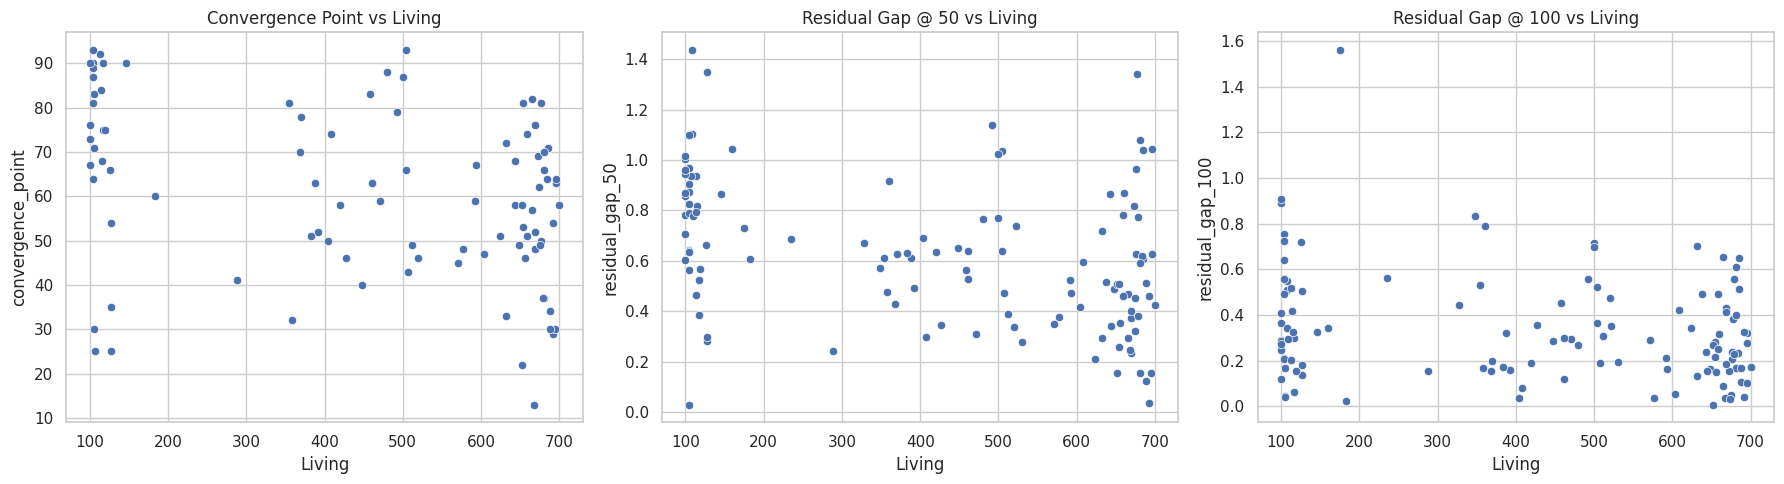

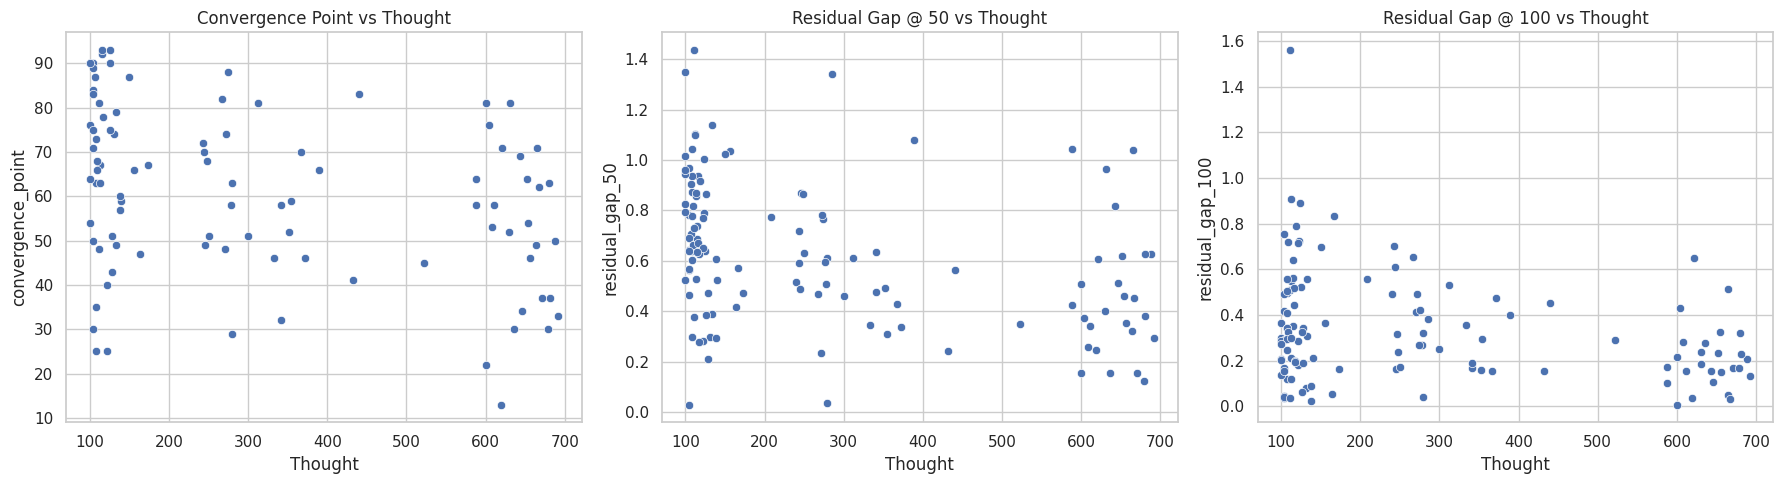

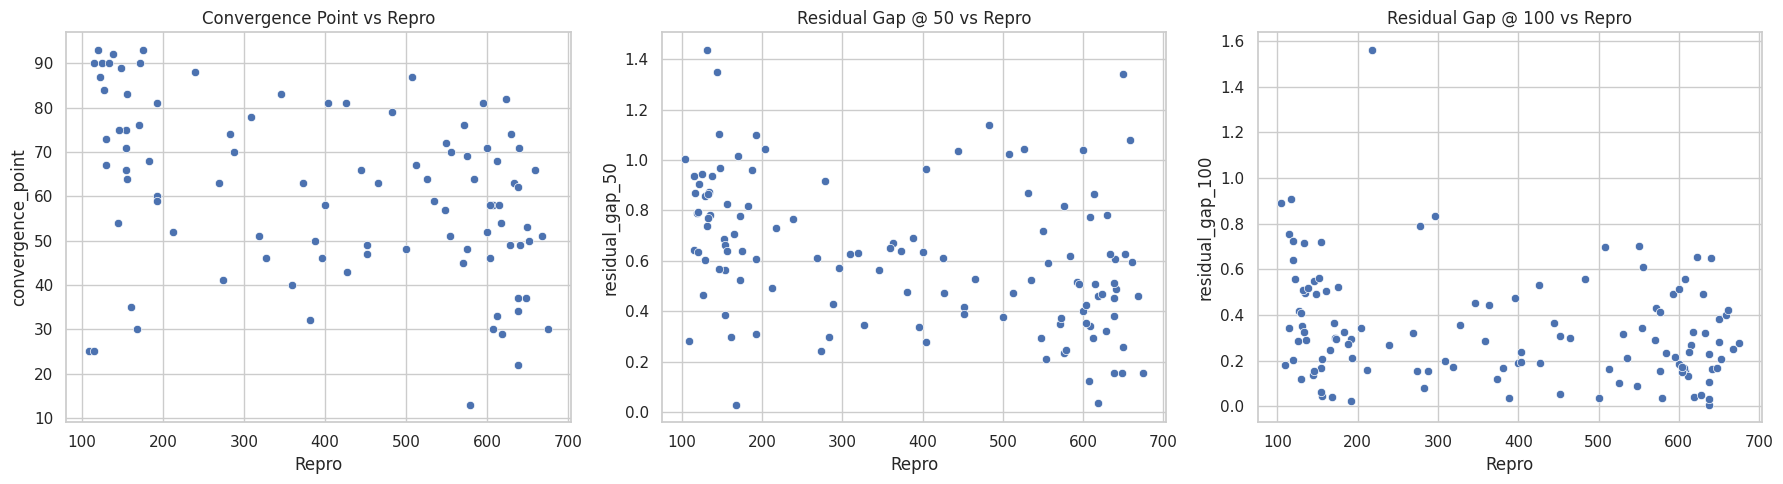

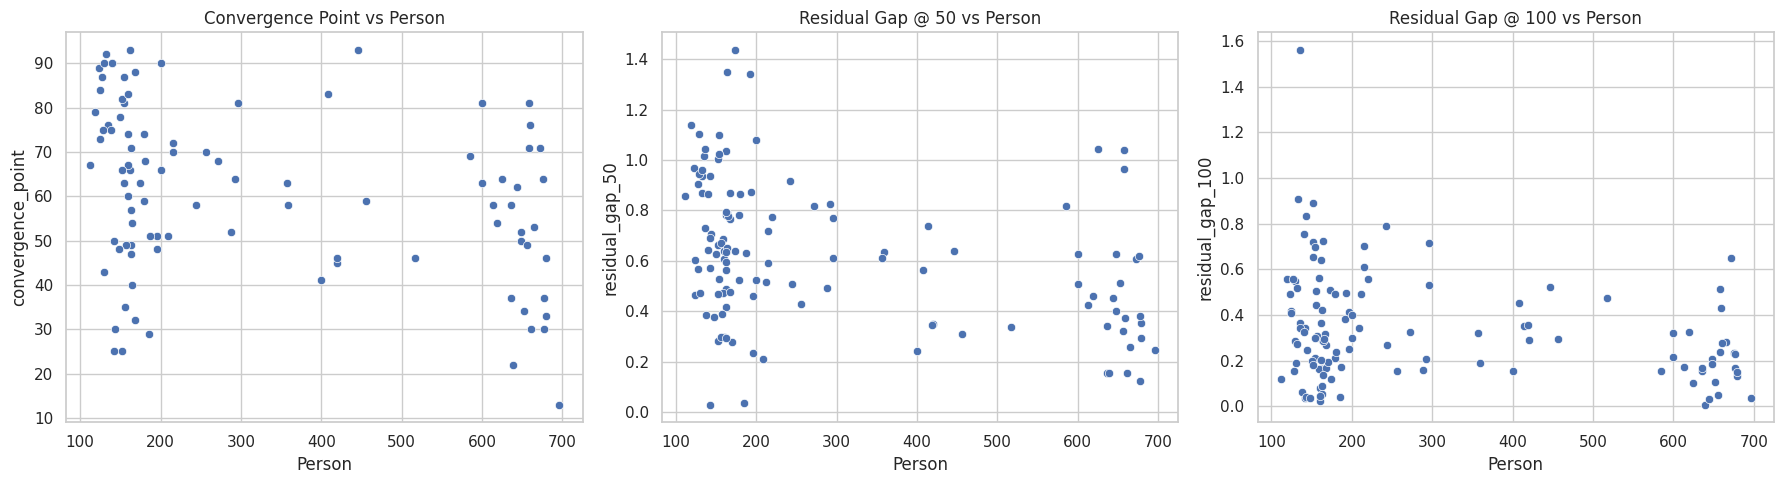

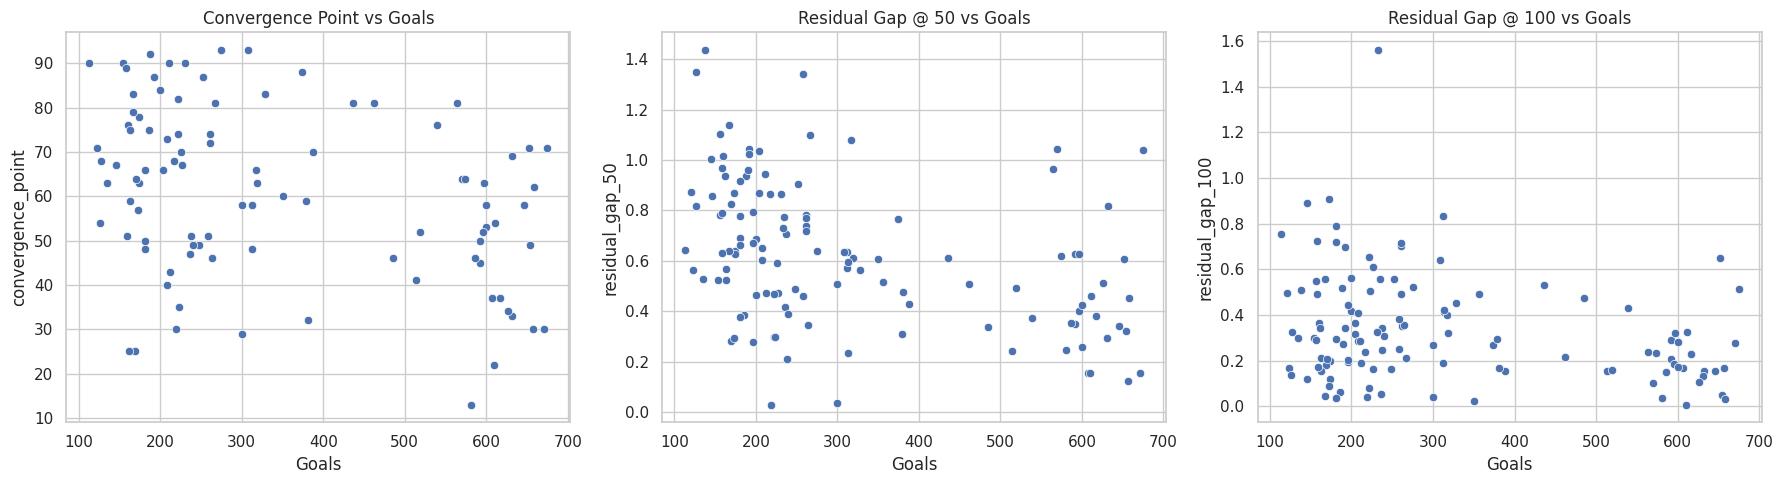

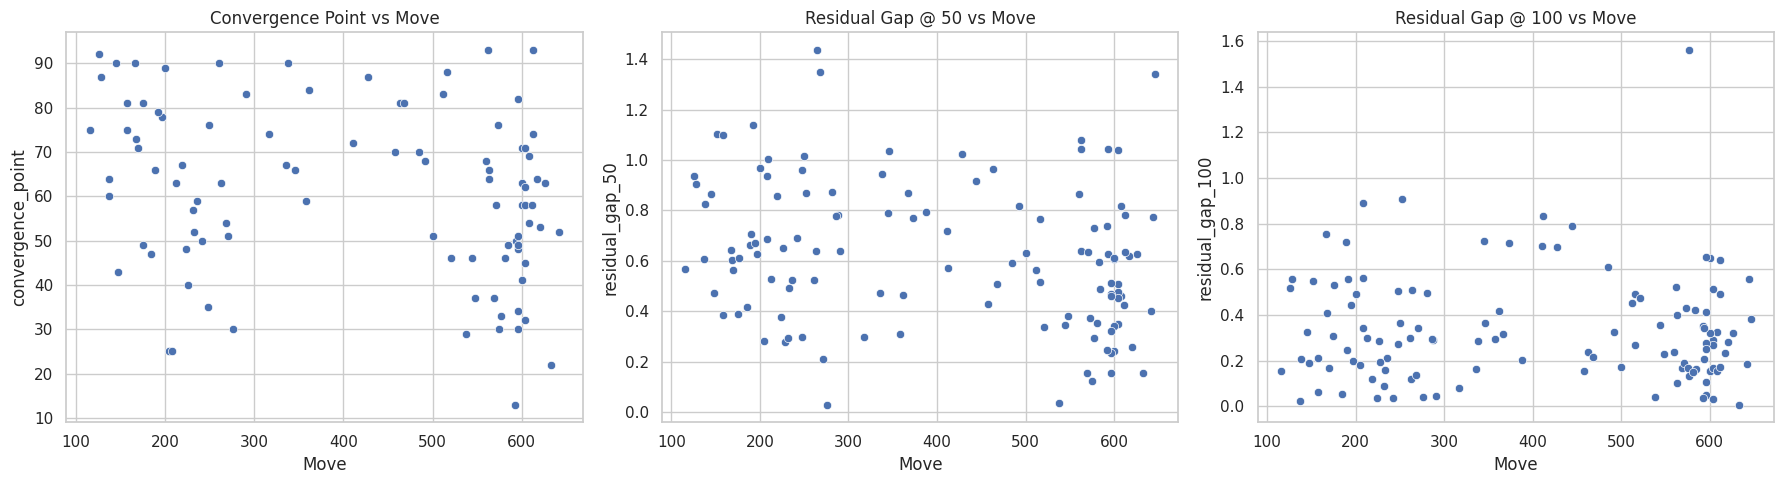

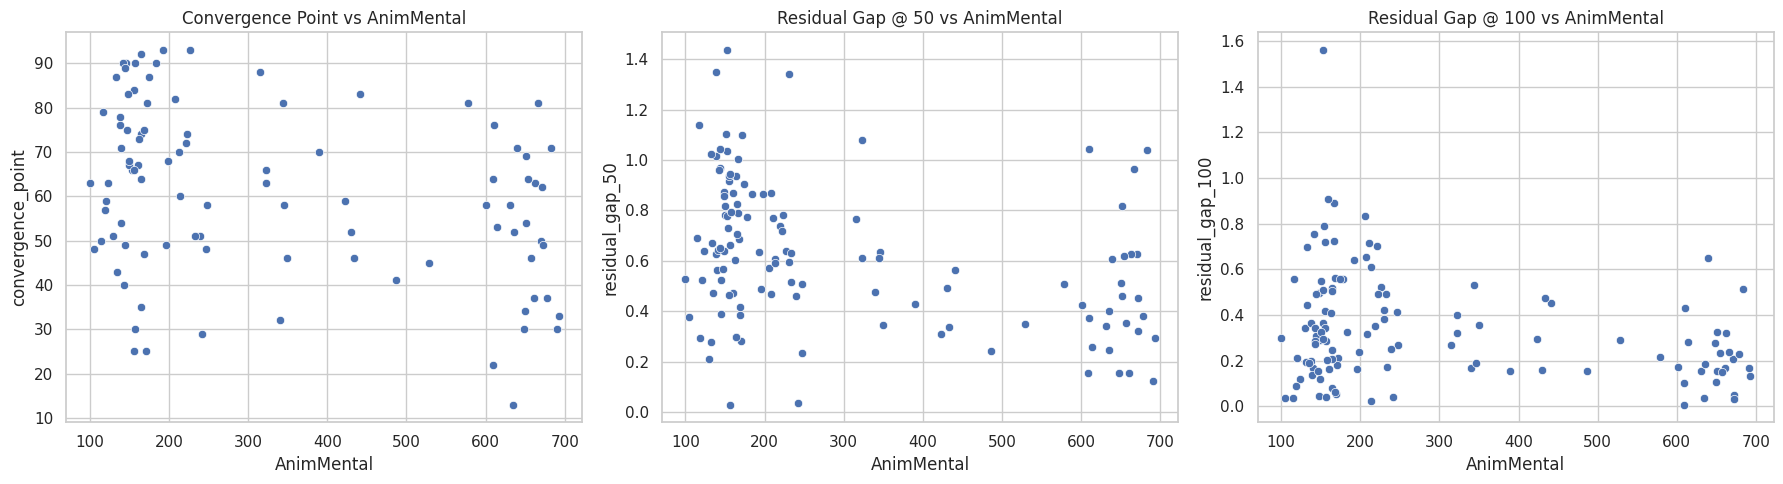

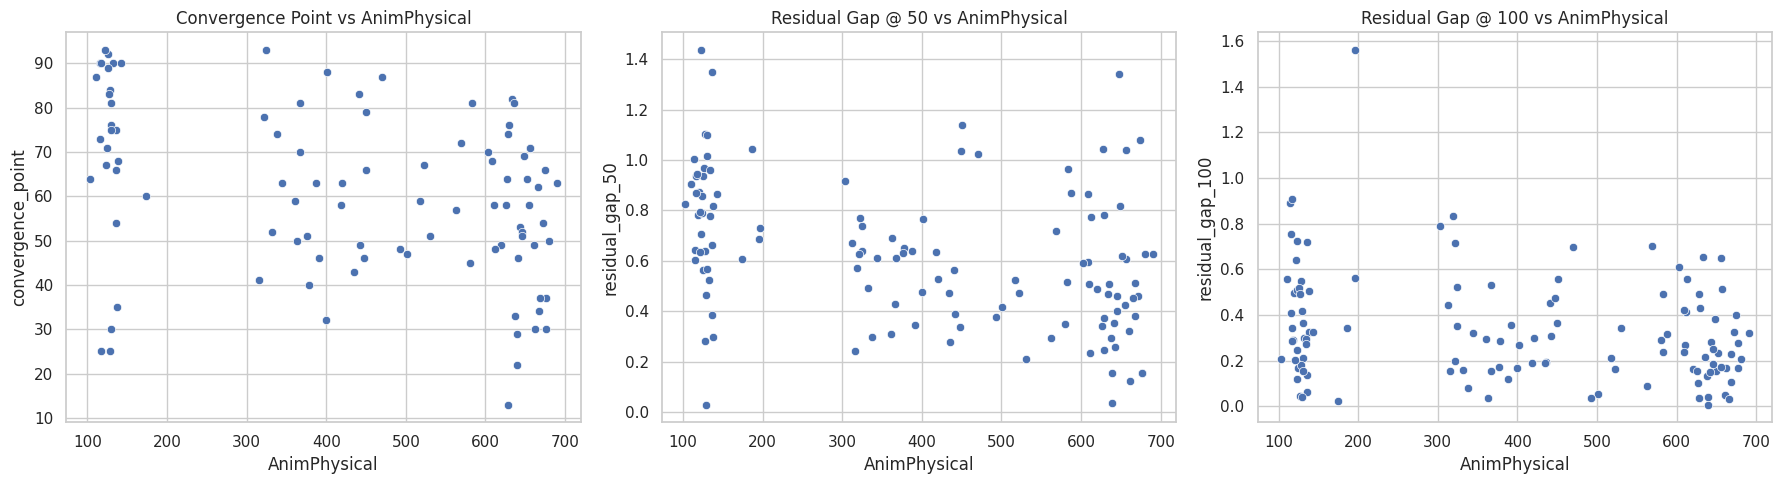

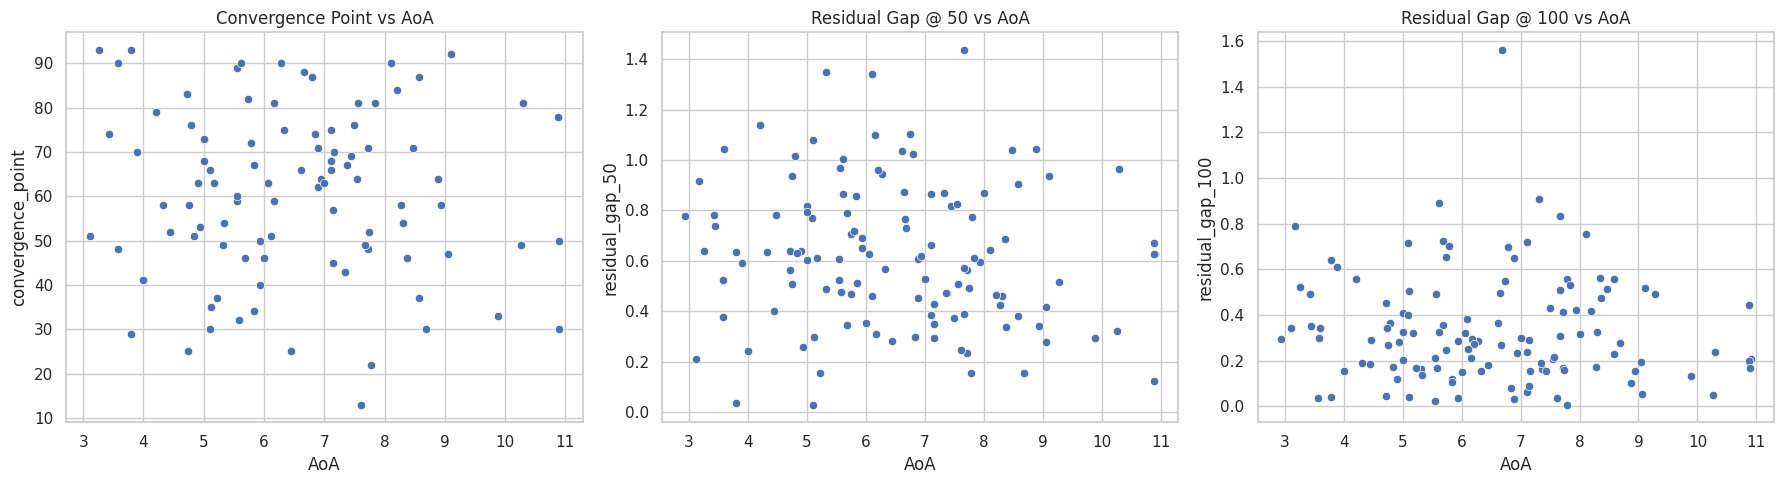

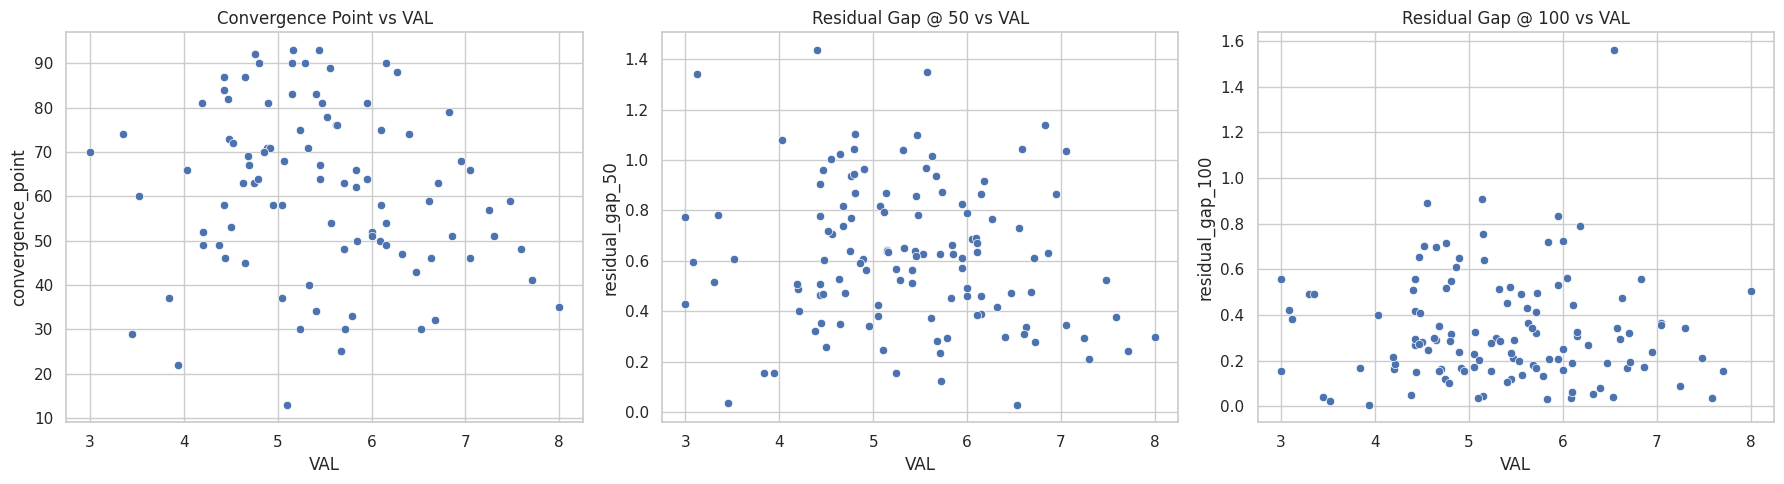

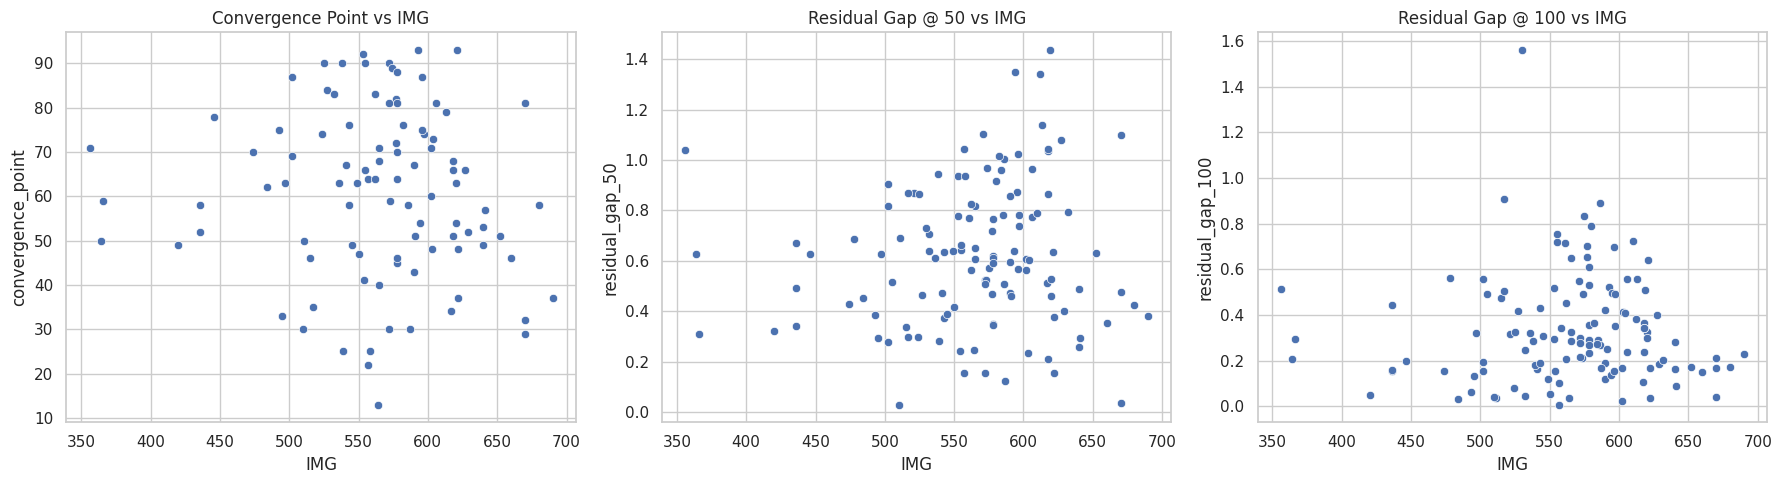

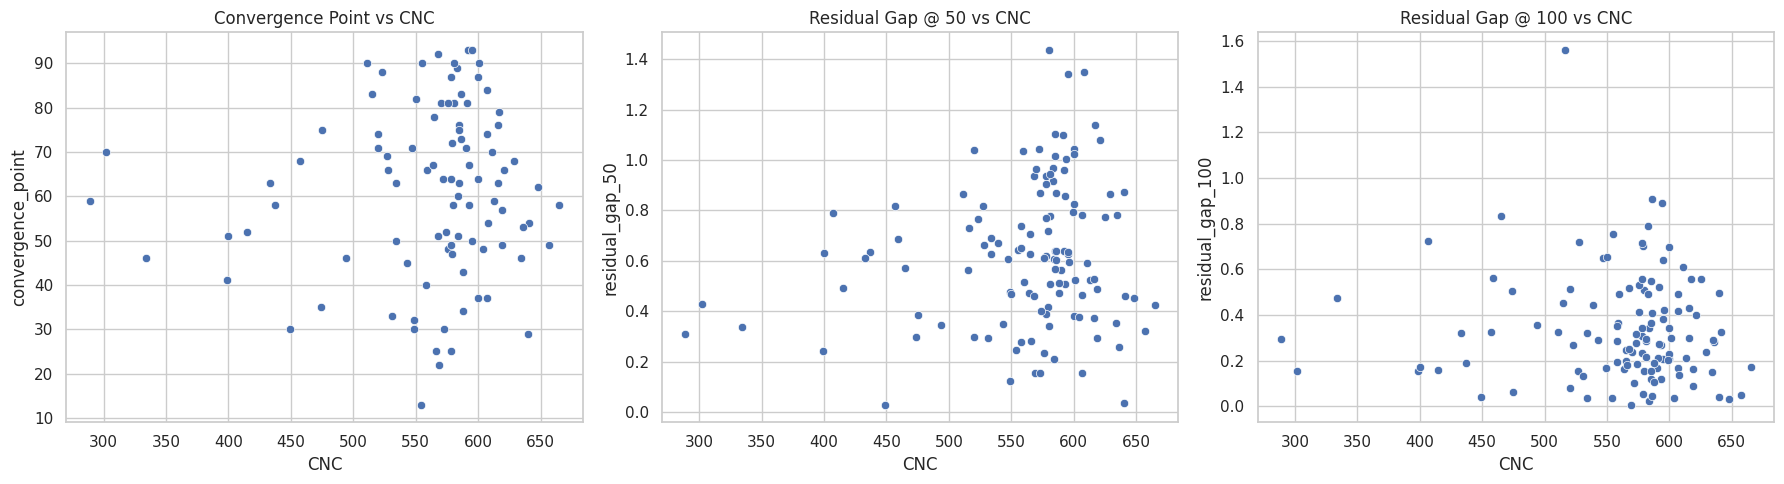

In [9]:
roles = df_clean['role_name'].unique()
role_convergence = {}
role_residual_gap_50 = {}
role_residual_gap_100 = {}

for role in roles:
    role_df = df_clean[df_clean['role_name'] == role]
    traj_sys = get_avg_trajectory(role_df['first_100_response_log_probs'])
    traj_no_sys = get_avg_trajectory(role_df['first_100_response_log_probs_no_sys'])
    
    diff = np.abs(traj_sys - traj_no_sys)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    role_convergence[role] = conv_idx
    role_residual_gap_50[role] = get_residual_gap_at_k(traj_sys, traj_no_sys, 49)
    role_residual_gap_100[role] = get_residual_gap_at_k(traj_sys, traj_no_sys, 99)

role_conv_df = pd.DataFrame({
    'role_name': list(role_convergence.keys()),
    'convergence_point': list(role_convergence.values()),
    'residual_gap_50': list(role_residual_gap_50.values()),
    'residual_gap_100': list(role_residual_gap_100.values())
})

# Merge with norms
role_conv_full = pd.merge(role_conv_df, df_norms, left_on=role_conv_df['role_name'].str.lower(), right_on='Word_lower', how='left')

properties = ['Living', 'Thought', 'Repro', 'Person', 'Goals', 'Move', 'AnimMental', 'AnimPhysical', 'AoA', 'VAL', 'IMG', 'CNC']

for prop in properties:
    if prop in role_conv_full.columns:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
        
        sns.scatterplot(data=role_conv_full, x=prop, y='convergence_point', ax=ax1)
        ax1.set_title(f'Convergence Point vs {prop}')
        
        sns.scatterplot(data=role_conv_full, x=prop, y='residual_gap_50', ax=ax2)
        ax2.set_title(f'Residual Gap @ 50 vs {prop}')
        
        sns.scatterplot(data=role_conv_full, x=prop, y='residual_gap_100', ax=ax3)
        ax3.set_title(f'Residual Gap @ 100 vs {prop}')
        
        plt.tight_layout()
        plt.show()

## 5) Convergence and Residual Gap vs No-Sys Avg Logits

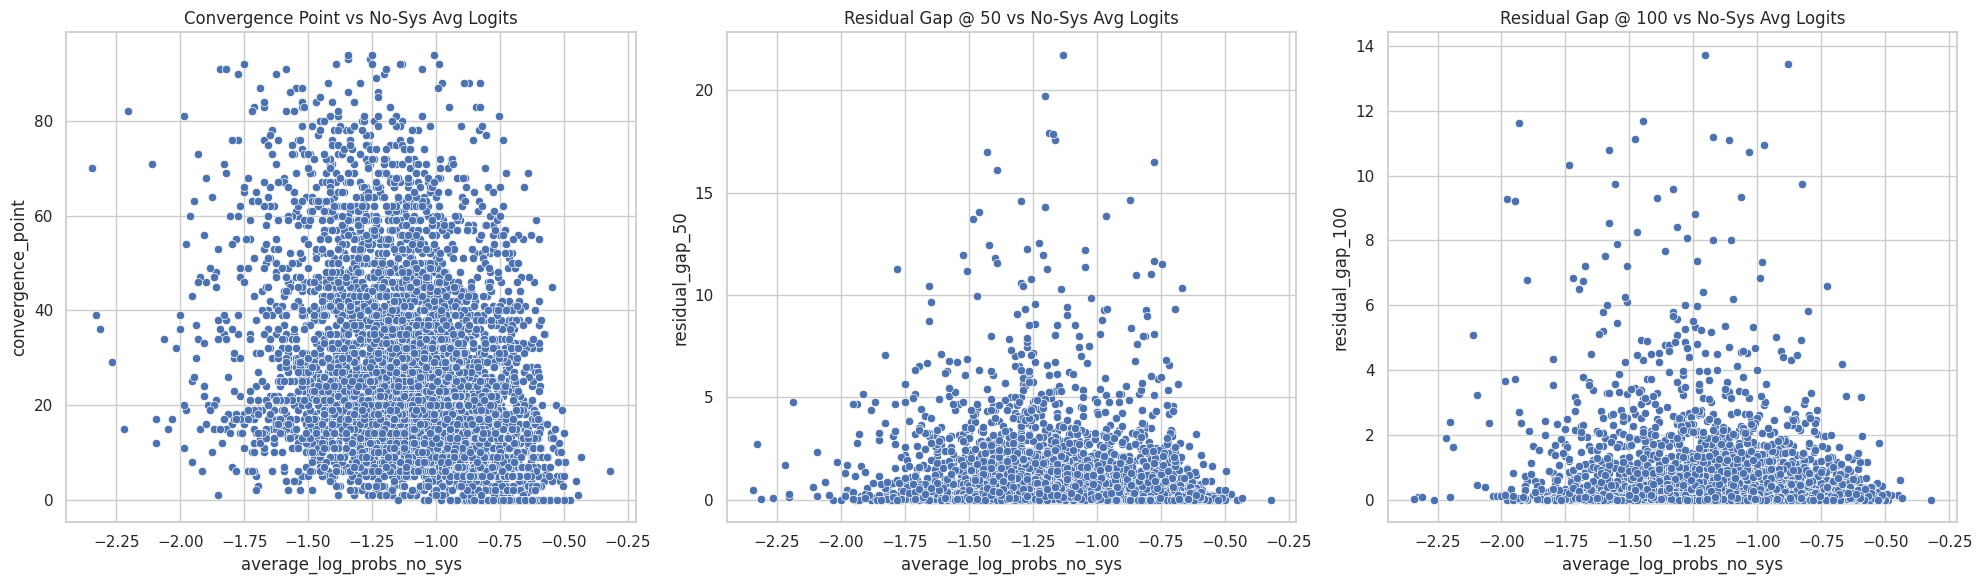

In [10]:
def get_convergence_and_gaps_single(row):
    l1 = row['first_100_response_log_probs']
    l2 = row['first_100_response_log_probs_no_sys']
    if not isinstance(l1, list) or not isinstance(l2, list): return np.nan, np.nan, np.nan
    
    min_len = min(len(l1), len(l2))
    if min_len < 10: return np.nan, np.nan, np.nan
    
    arr1 = np.array(l1[:min_len])
    arr2 = np.array(l2[:min_len])
    
    diff = np.abs(arr1 - arr2)
    conv_idx = np.nan
    for idx in range(len(diff) - 5):
        if np.all(diff[idx:idx+5] < 0.5):
            conv_idx = idx
            break
    
    gap_50 = diff[49] if min_len > 49 else np.nan
    gap_100 = diff[99] if min_len > 99 else np.nan
        
    return conv_idx, gap_50, gap_100

results = df_clean.apply(get_convergence_and_gaps_single, axis=1, result_type='expand')
df_clean['convergence_point'] = results[0]
df_clean['residual_gap_50'] = results[1]
df_clean['residual_gap_100'] = results[2]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='convergence_point', ax=ax1)
ax1.set_title('Convergence Point vs No-Sys Avg Logits')

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='residual_gap_50', ax=ax2)
ax2.set_title('Residual Gap @ 50 vs No-Sys Avg Logits')

sns.scatterplot(data=df_clean, x='average_log_probs_no_sys', y='residual_gap_100', ax=ax3)
ax3.set_title('Residual Gap @ 100 vs No-Sys Avg Logits')

plt.tight_layout()
plt.show()

## 6) Logit Change vs Role Properties

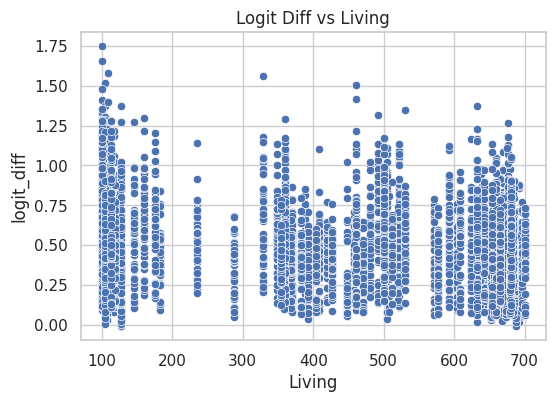

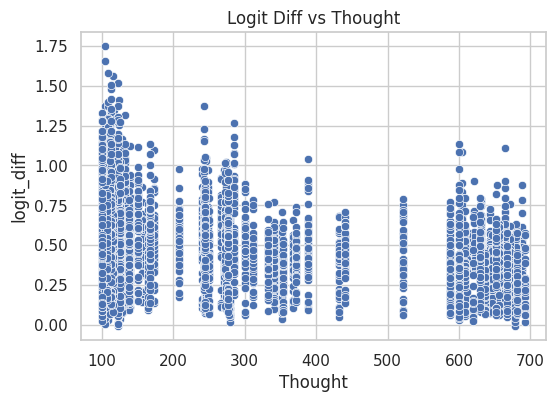

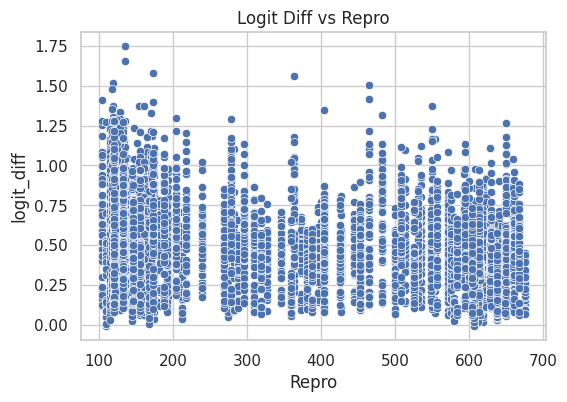

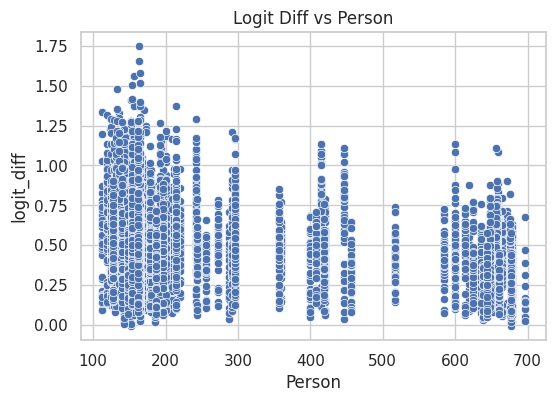

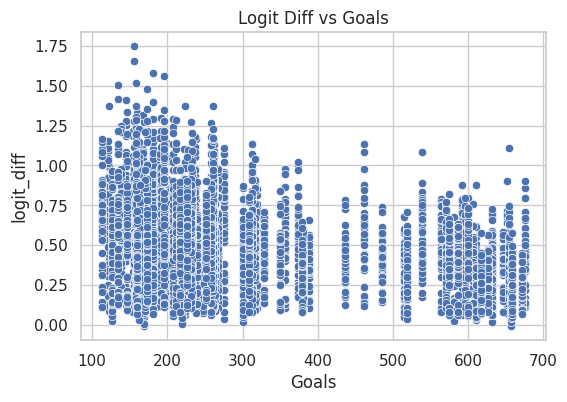

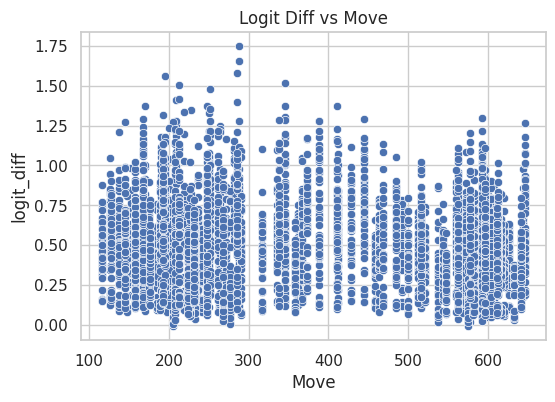

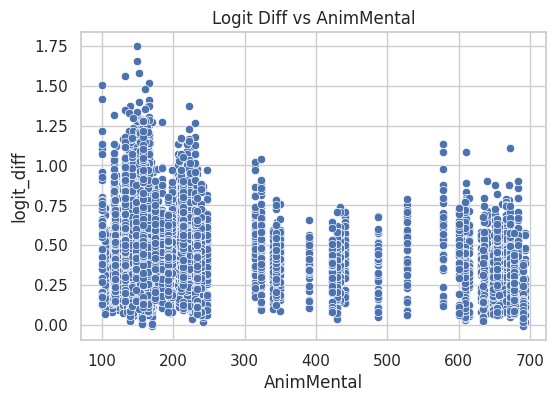

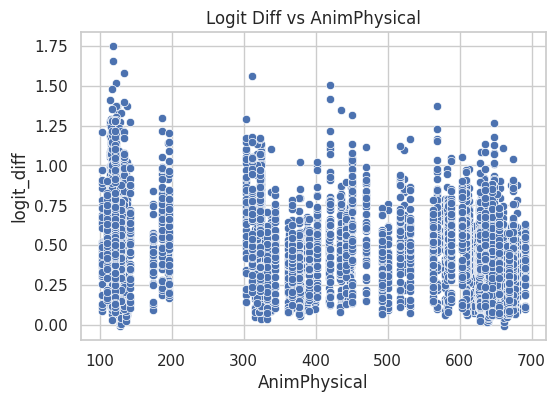

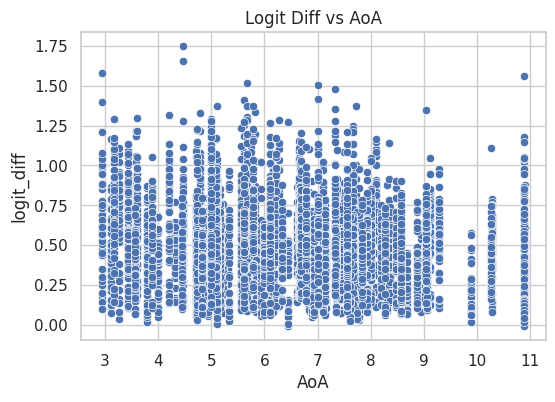

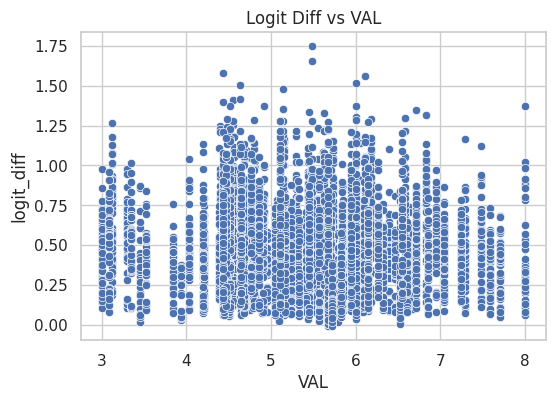

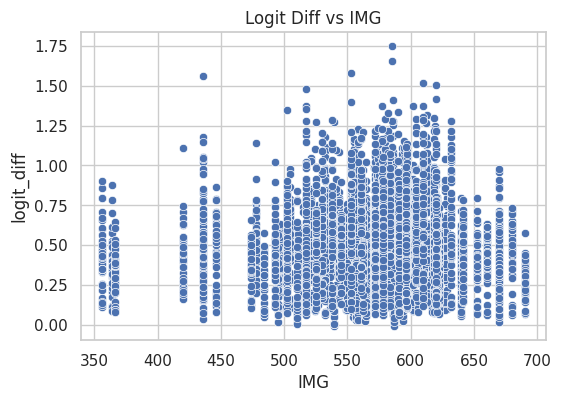

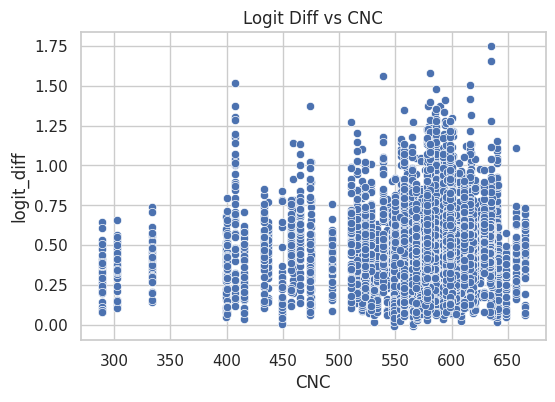

In [11]:
df_clean['logit_diff'] = df_clean['average_log_probs'] - df_clean['average_log_probs_no_sys']

for prop in properties:
    if prop in df_clean.columns:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(data=df_clean, x=prop, y='logit_diff')
        plt.title(f'Logit Diff vs {prop}')
        plt.show()